In [ ]:
!pip install openpyxl
!pip install lazypredict

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from lazypredict.Supervised import LazyRegressor

In [ ]:
# Load your dataset from Excel
file_path = '/content/Dataset.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Shuffle the DataFrame rows randomly
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,Temperature,SR,SV,Si,Edge,Fstrength,fstrain,Y
0,900.00,0.00,0.50,0.00,Armchair,156.00,0.23,1.27
1,300.00,0.01,0.50,1.00,Armchair,166.20,0.24,2.14
2,900.00,0.00,0.50,0.00,Armchair,157.00,0.23,1.49
3,900.00,0.00,0.50,1.00,Armchair,151.90,0.22,1.97
4,600.00,0.00,0.50,1.00,Armchair,160.10,0.23,2.06


In [ ]:
# Indentifying Input features (X), and Responses (y1, y2, and y3)
X = df[['Temperature', 'SR', 'SV', 'Si', 'Edge']]
y = df['Fstrength']

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [ ]:
# Identify categorical features
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

categorical_features = ['Edge']

# Preprocessing categorical features with one-hot encoding
# Preprocessing continuous features with StandarScaler (z-score)
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scale', StandardScaler(), ['Temperature', 'SR', 'SV', 'Si'])
])

In [ ]:
# Transform input features
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_val_transformed = preprocessor.transform(X_val)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

# Initialize LazyRegressor
lazy_reg = LazyRegressor()

# Fit and evaluate models for y
y_models, y_preds = lazy_reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)
print("Results for Fstrength:\n", y_models)

100%|██████████| 42/42 [00:08<00:00,  4.93it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 244, number of used features: 6
[LightGBM] [Info] Start training from score 171.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

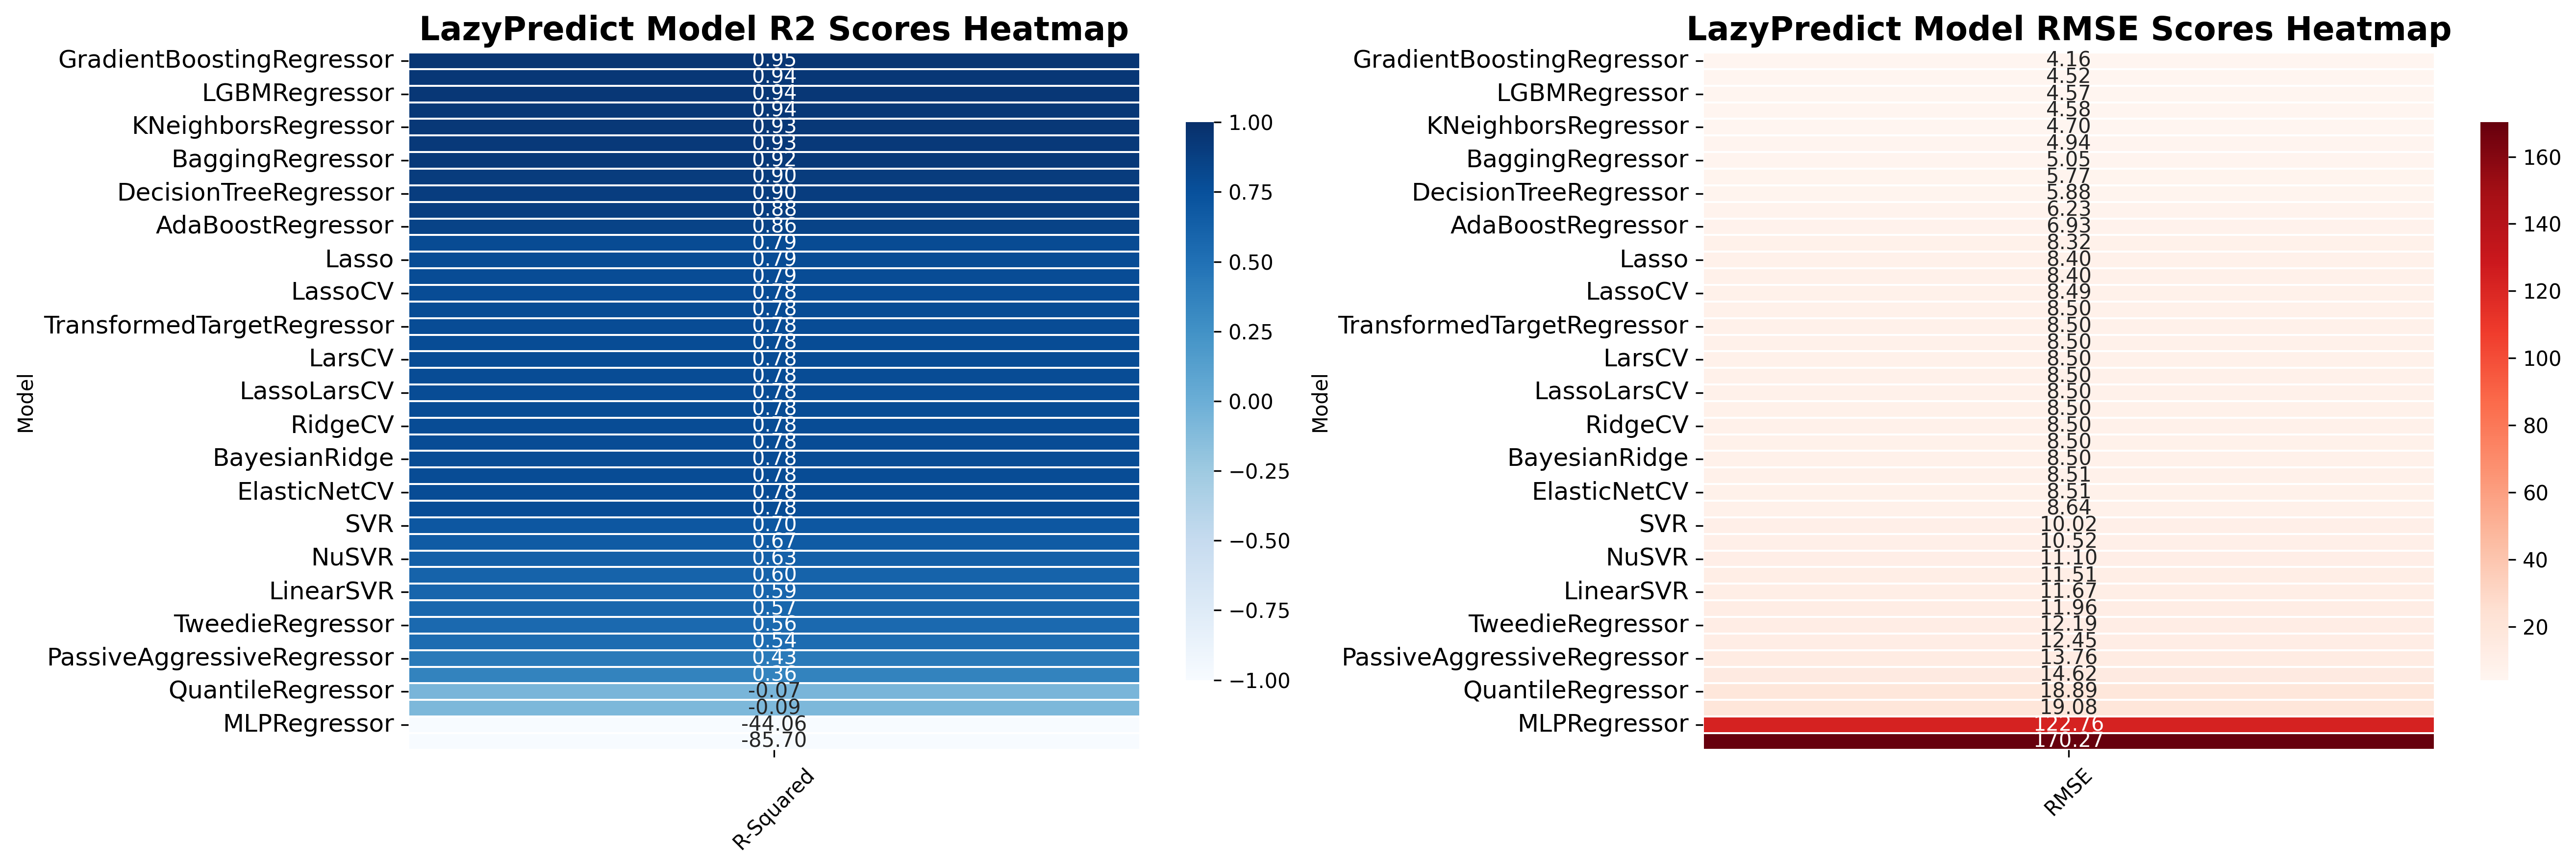

In [ ]:
# Subplot for R2 and RMSE heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=300)
sns.heatmap(y_models[['R-Squared']], annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("LazyPredict Model R2 Scores Heatmap", fontsize=16, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', labelsize=12)

sns.heatmap(y_models[['RMSE']], annot=True, cmap='Reds', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, ax=axes[1])
axes[1].set_title("LazyPredict Model RMSE Scores Heatmap", fontsize=16, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("lazypredict_performance_heatmaps.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define models
bagging_model = BaggingRegressor(random_state=42)  # Bagging Regressor
lgbm_model = LGBMRegressor(random_state=42)  # LGBM Regressor

In [ ]:
# Hyperparameter tuning for Bagging Regressor
param_grid_bagging = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],  # fraction of samples to use for each base model
    'max_features': [0.5, 0.8, 1.0],  # fraction of features to use for each base model
}

# Hyperparameter tuning for LGBM Regressor
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

In [ ]:
# Grid search with cross-validation
bagging_grid = GridSearchCV(bagging_model, param_grid_bagging, cv=5, scoring='r2')
lgbm_grid = GridSearchCV(lgbm_model, param_grid_lgbm, cv=5, scoring='r2')

In [ ]:
# Fit models
bagging_grid.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42),
             param_grid={'max_features': [0.5, 0.8, 1.0],
                         'max_samples': [0.5, 0.8, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [ ]:
lgbm_grid.fit(X_train_transformed, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50, 100]},
             scoring='r2')

In [ ]:
# Evaluate models with 5-fold CV
bagging_cv_scores = cross_val_score(bagging_grid.best_estimator_, X_train_transformed, y_train, cv=5, scoring='r2')
lgbm_cv_scores = cross_val_score(lgbm_grid.best_estimator_, X_train_transformed, y_train, cv=5, scoring='r2')

print("Bagging Regressor CV Scores:", bagging_cv_scores)
print("LGBM Regressor CV Scores:", lgbm_cv_scores)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 6
[LightGBM] [Info] Start training from score 171.647180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
print("Best Hyperparameters for Bagging Regressor:", bagging_grid.best_params_)
print("Best Score from Grid Search:", bagging_grid.best_score_)
print("Best Hyperparameters for LGBM Regressor:", lgbm_grid.best_params_)
print("Best Score from Grid Search:", lgbm_grid.best_score_)

Best Hyperparameters for Bagging Regressor: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
Best Score from Grid Search: 0.9406393170513068
Best Hyperparameters for LGBM Regressor: {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 31}
Best Score from Grid Search: 0.9376572401880703


In [ ]:
# Predict on test data
y_pred_bagging_test = bagging_grid.best_estimator_.predict(X_test_transformed)
y_pred_bagging_val = bagging_grid.best_estimator_.predict(X_val_transformed)
y_pred_lgbm_test = lgbm_grid.best_estimator_.predict(X_test_transformed)
y_pred_lgbm_val = lgbm_grid.best_estimator_.predict(X_val_transformed)

In [ ]:
# Compute relative errors
relative_error_bagging_train = (bagging_grid.best_estimator_.predict(X_train_transformed) - y_train) / y_train
relative_error_bagging_test = (y_pred_bagging_test - y_test) / y_test
relative_error_bagging_val = (y_pred_bagging_val - y_val) / y_val
relative_error_lgbm_train = (lgbm_grid.best_estimator_.predict(X_train_transformed) - y_train) / y_train
relative_error_lgbm_test = (y_pred_lgbm_test - y_test) / y_test
relative_error_lgbm_val = (y_pred_lgbm_val - y_val) / y_val

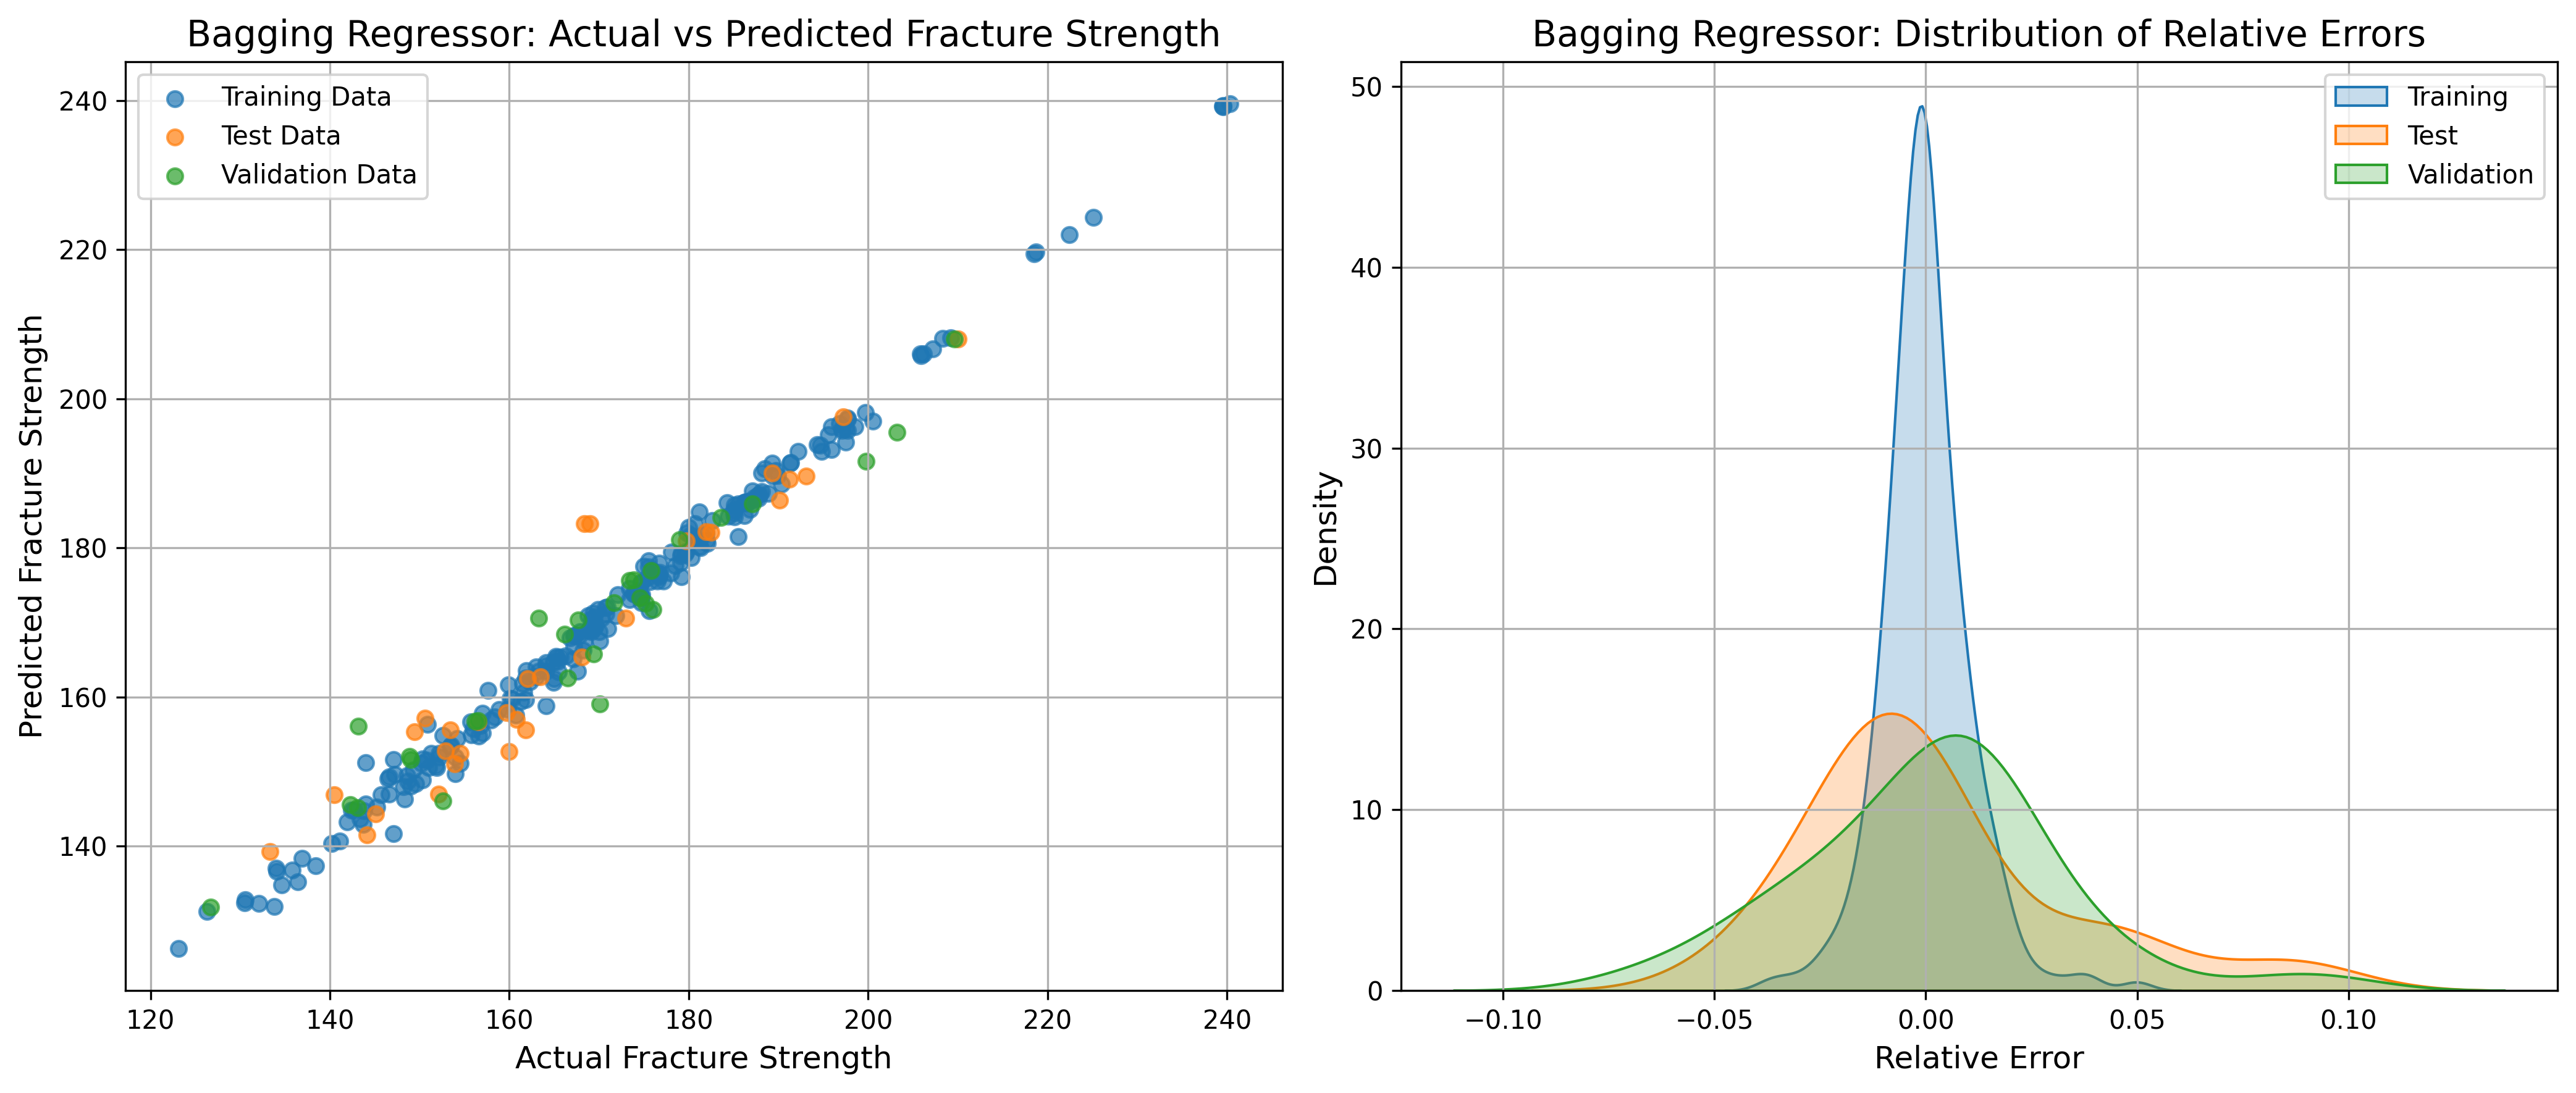

In [ ]:
# High-quality Bagging Regressor plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0].scatter(y_train, bagging_grid.best_estimator_.predict(X_train_transformed), label='Training Data', alpha=0.7)
axes[0].scatter(y_test, y_pred_bagging_test, label='Test Data', alpha=0.7)
axes[0].scatter(y_val, y_pred_bagging_val, label='Validation Data', alpha=0.7)
axes[0].set_xlabel('Actual Fracture Strength', fontsize=12)
axes[0].set_ylabel('Predicted Fracture Strength', fontsize=12)
axes[0].set_title('Bagging Regressor: Actual vs Predicted Fracture Strength', fontsize=14)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(relative_error_bagging_train, label='Training', fill=True, ax=axes[1])
sns.kdeplot(relative_error_bagging_test, label='Test', fill=True, ax=axes[1])
sns.kdeplot(relative_error_bagging_val, label='Validation', fill=True, ax=axes[1])
axes[1].set_xlabel('Relative Error', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Bagging Regressor: Distribution of Relative Errors', fontsize=14)
axes[1].legend()
axes[1].grid(True)
plt.savefig("Bagging Regressor.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

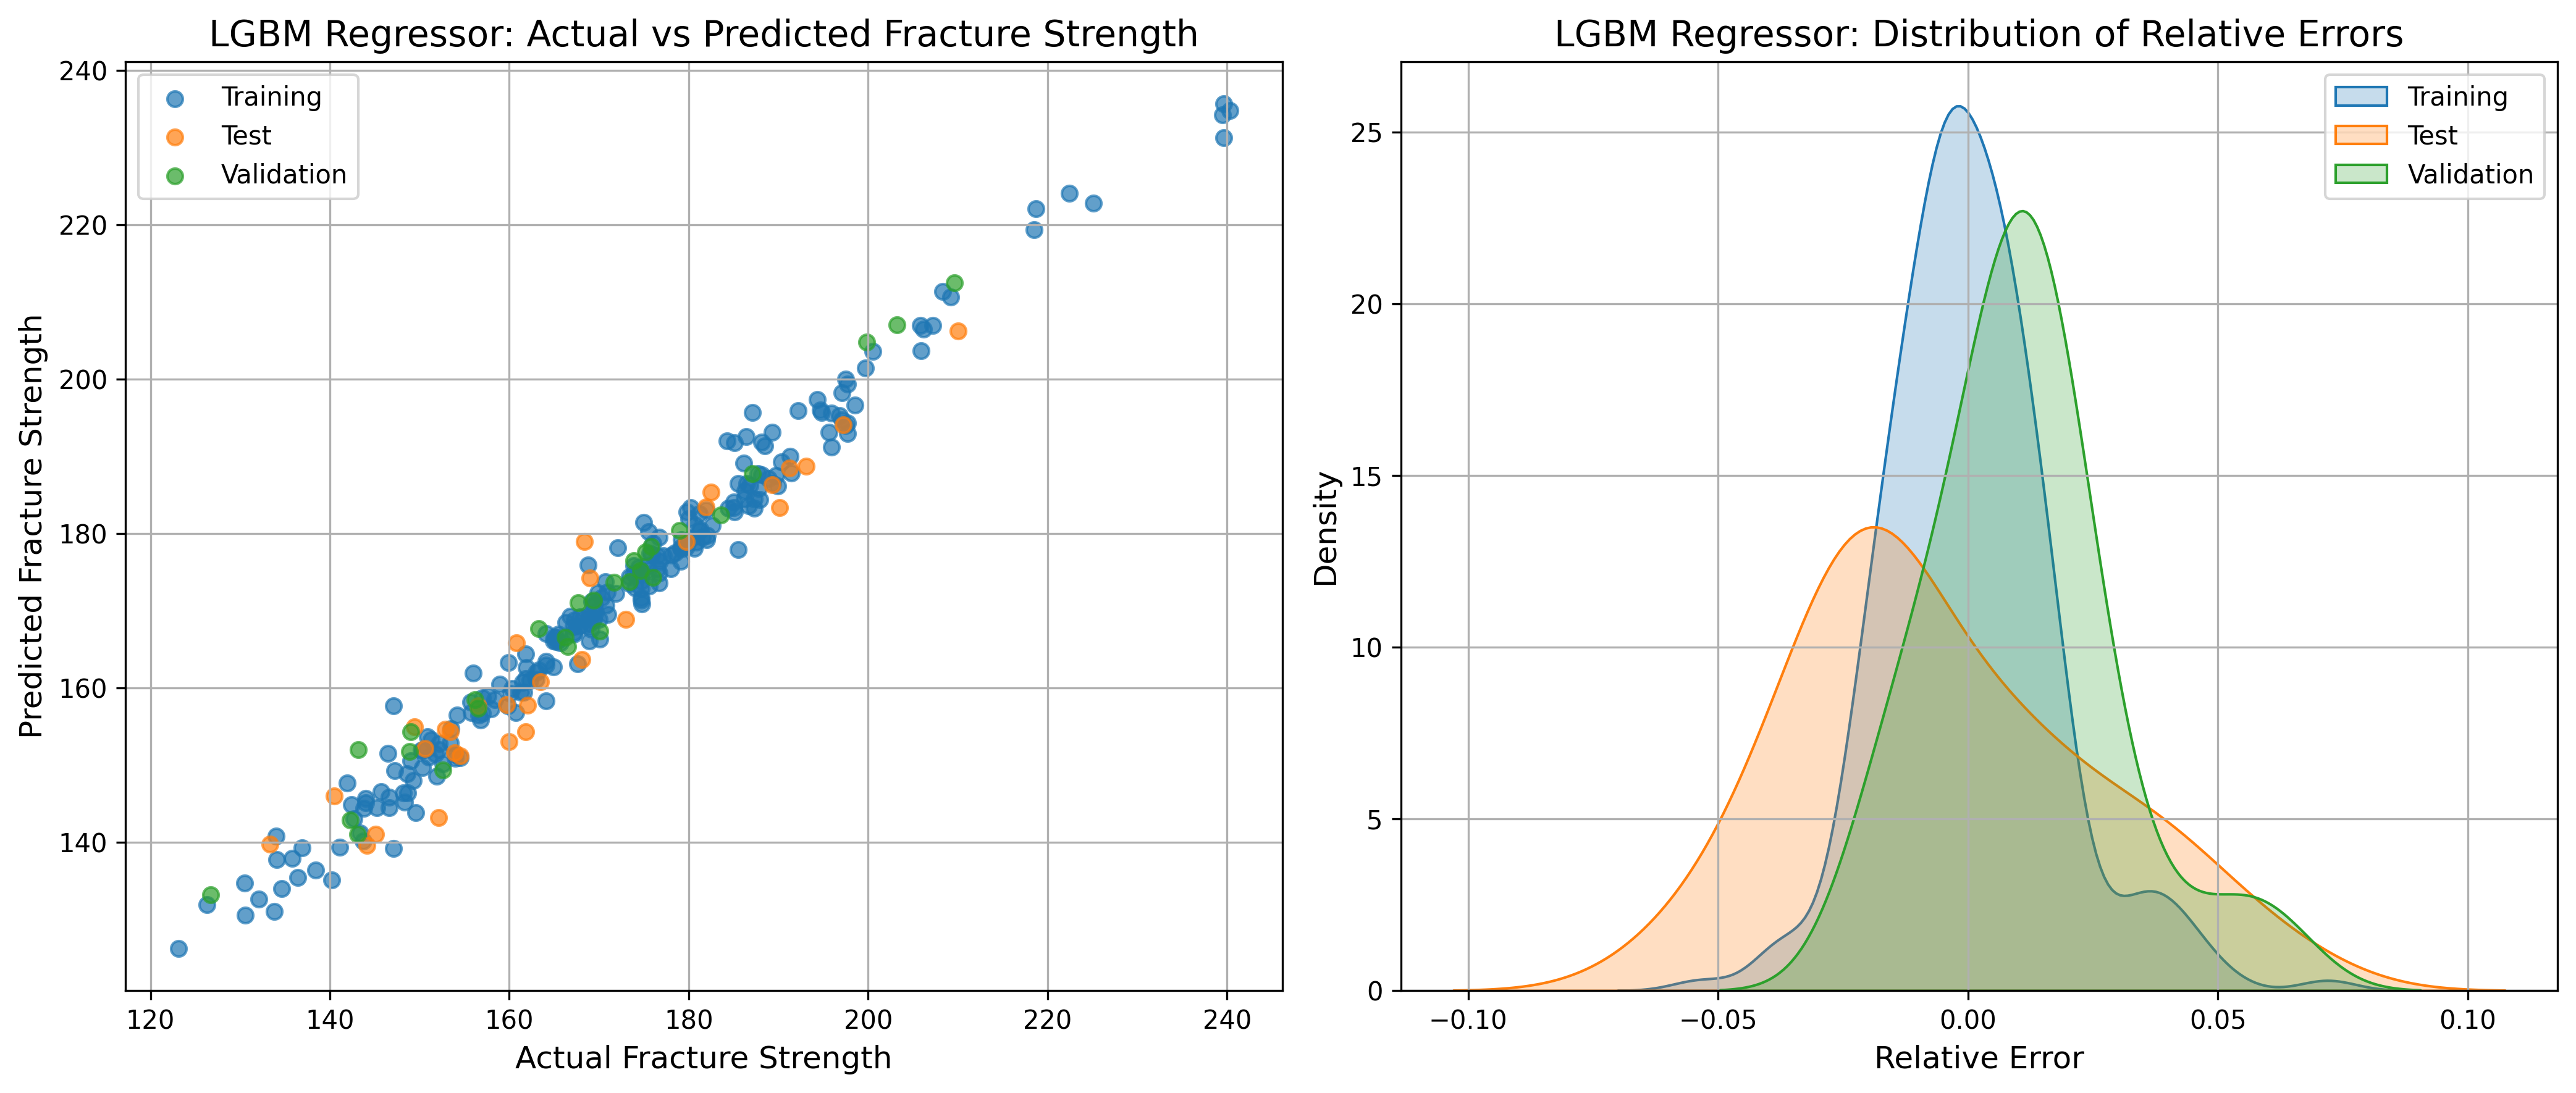

In [ ]:
# High-quality LGBM Regressor plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0].scatter(y_train, lgbm_grid.best_estimator_.predict(X_train_transformed), label='Training', alpha=0.7)
axes[0].scatter(y_test, y_pred_lgbm_test, label='Test', alpha=0.7)
axes[0].scatter(y_val, y_pred_lgbm_val, label='Validation', alpha=0.7)
axes[0].set_xlabel('Actual Fracture Strength', fontsize=12)
axes[0].set_ylabel('Predicted Fracture Strength', fontsize=12)
axes[0].set_title('LGBM Regressor: Actual vs Predicted Fracture Strength', fontsize=14)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(relative_error_lgbm_train, label='Training', fill=True, ax=axes[1])
sns.kdeplot(relative_error_lgbm_test, label='Test', fill=True, ax=axes[1])
sns.kdeplot(relative_error_lgbm_val, label='Validation', fill=True, ax=axes[1])
axes[1].set_xlabel('Relative Error', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('LGBM Regressor: Distribution of Relative Errors', fontsize=14)
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()